# MeerKAT as a Phased Array

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.signal import find_peaks

# ---------- Matplotlib Settings ----------

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

sns.set_context("notebook", font_scale=1)

from IPython.display import set_matplotlib_formats

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import matplotlib.pylab as pylab

params = {
    'axes.titlesize':'xx-large',
    'axes.labelsize': 'xx-large',
    'xtick.labelsize':'large',
    'ytick.labelsize':'large',
    'legend.fontsize': 'large',
    'lines.linewidth': 2.5
}

pylab.rcParams.update(params)

# -----------------------------------------

from phasedarraylib.arrays import Array, RandomCircularArray
from phasedarraylib.utilities import decibel, arg_closest

## MeerKAT Position Data

In [2]:
positions = pd.read_csv('MeerKAT_antenna_positions.csv', sep=',', skiprows=17, nrows=64, usecols=[1, 2, 3], names=['east', 'north', 'up'])

In [60]:
positions['east-north'] = np.sqrt(positions['east'] ** 2 + positions['north'] ** 2)

In [62]:
positions.head()

,east,north,up,east-north
0,-8.264,-207.290,8.597,207.454664
1,1.121,-171.762,8.471,171.765658
2,-32.113,-224.236,8.645,226.523792
3,-66.518,-202.276,8.285,212.932441
4,-123.624,-252.946,8.513,281.539646


In [122]:
np.floor(0.1 * 64)

6.0

In [123]:
positions[:6]

,east,north,up,east-north
0,-8.264,-207.290,8.597,207.454664
1,1.121,-171.762,8.471,171.765658
2,-32.113,-224.236,8.645,226.523792
3,-66.518,-202.276,8.285,212.932441
4,-123.624,-252.946,8.513,281.539646
5,-102.088,-283.120,8.875,300.963277


In [121]:
positions.shape[0]

64

In [132]:
def select_from_center(percentage, p_df):
    fraction = percentage/100
    size = p_df.shape[0]
    
    p_sorted = p_df.sort_values('east-north')
    
    n_ant = int(np.floor(fraction * size))
    
    return p_sorted[:n_ant], n_ant

In [133]:
select_from_center(30, positions)

(       east    north      up  east-north
 27   40.475  -23.112   7.694   46.608907
 26  -99.004   17.045   6.811  100.460560
 28  -51.179  -87.170   7.636  101.083624
 29  -88.762 -124.111   7.700  152.585166
 1     1.121 -171.762   8.471  171.765658
 30  171.281  113.949   7.278  205.722035
 0    -8.264 -207.290   8.597  207.454664
 3   -66.518 -202.276   8.285  212.932441
 2   -32.113 -224.236   8.645  226.523792
 17  199.624 -112.263   8.955  229.025594
 31  246.567   93.756   7.469  263.790586
 18  105.727 -245.870   9.529  267.638292
 4  -123.624 -252.946   8.513  281.539646
 25 -181.978  225.617   5.068  289.860351
 6   -18.232 -295.428   9.188  295.990049
 5  -102.088 -283.120   8.875  300.963277
 15  210.644 -219.142   9.738  303.963996
 20   97.016 -299.638   9.877  314.952433
 19  170.787 -285.223  10.071  332.446024,
 19)

## The MeerKAT Array

For more info on MeerKAT: https://skaafrica.atlassian.net/wiki/spaces/ESDKB/pages/277315585/MeerKAT+specifications

In [4]:
frequency = 580 # MHz

In [5]:
meerkat = Array()

meerkat_positions = positions[['east', 'north']].to_numpy()
meerkat.set_element_positions(meerkat_positions)

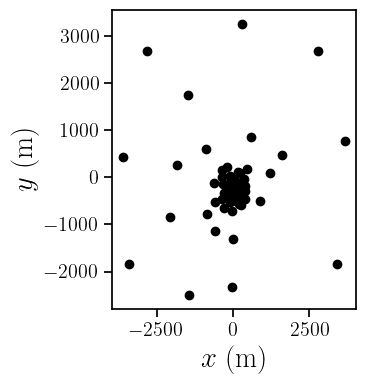

In [6]:
meerkat.plot_configuration()

## Antenna Selection

## Array Response

In [7]:
uv_range = (-0.005, 0.005)

In [99]:
response = meerkat.evaluate_array_factor(frequency, sample_count=2001, range=uv_range)

### 2D Beam

In [100]:
af = response.get('af')
af /= af.max()

af_db = decibel(af)

In [101]:
print('AF_min (dB) = {}'.format(af_db.min()))

AF_min (dB) = -80.9936035070323


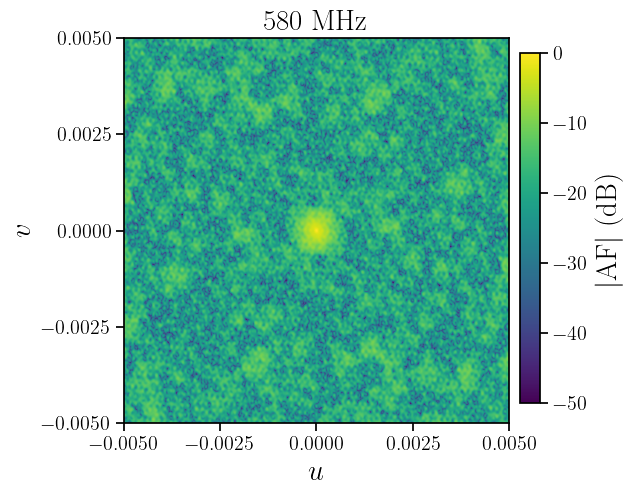

In [102]:
fig, frame = plt.subplots(figsize=(5, 5))



image = frame.imshow(af_db, origin='lower', vmin=-50, vmax=0, extent=(uv_range[0], uv_range[1], uv_range[0], uv_range[1]))

frame.update(dict(
    title='{} MHz'.format(frequency),
    xlabel=r'$u$',
    ylabel=r'$v$',
    xticks=np.linspace(uv_range[0], uv_range[1], 5),
    yticks=np.linspace(uv_range[0], uv_range[1], 5)
))

cb_frame = fig.add_axes([0.92, 0.15, 0.04, 0.7])
colorbar = fig.colorbar(image, cax=cb_frame, label='$|\mathrm{AF}|$ (dB)')

plt.show()

### 1D Beam

In [103]:
af_2d = response.get('af')
af_u = af_2d[af_2d.shape[0]//2, :]
af_v = af_2d[:, af_2d.shape[1]//2]

u_vals = response.get('u')

ba = np.pi/2 - np.arccos(u_vals)
ba_deg = np.degrees(ba)
ba_arcmin = ba_deg * 60
ba_arcsec = ba_arcmin * 60

In [110]:
peaks, _ = find_peaks(-decibel(af_u), height=30)

In [113]:
u_vals.size // 2

1001

In [114]:
peaks - u_vals.size // 2

array([-993, -973, -945, -931, -802, -773, -587, -494, -477, -456, -187,
       -174, -160,  159,  173,  187,  476,  492,  586,  773,  802,  931,
        942,  971,  991])

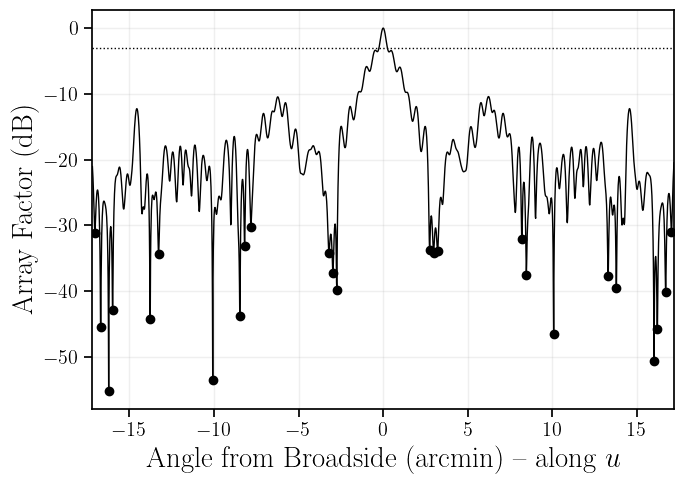

In [112]:
fig, frame = plt.subplots(figsize=(7, 5))

frame.plot(ba_arcmin, decibel(af_u), lw=1, color='black')
frame.plot(ba_arcmin[peaks], decibel(af_u)[peaks], ls='', marker='o', color='black')
# frame.plot(ba_arcmin, decibel(af_u), marker='*', ls='', lw=1, color='black')
frame.axhline(y=-3, color='black', ls=':', lw=1)

frame.update(dict(
    xlabel=r'Angle from Broadside (arcmin) -- along $u$',
    ylabel=r'Array Factor (dB)',
    xlim=(ba_arcmin.min(), ba_arcmin.max()),
    # xticks=np.arange(-1, 1.5, 0.5),
    # ylim=(-40, 0)
))

# frame.update(dict(
#     xlabel=r'Angle from Broadside (arcmin) -- along $u$',
#     ylabel=r'Array Factor (dB)',
#     xlim=(-0.5, 0.5),
#     # xlim=(ba_arcmin.min(), ba_arcmin.max()),
#     # xticks=np.arange(-1, 1.5, 0.5),
#     # ylim=(-40, 0)
#     ylim=(-10, 0)
# ))

frame.grid(alpha=0.2)

fig.tight_layout()
plt.show()

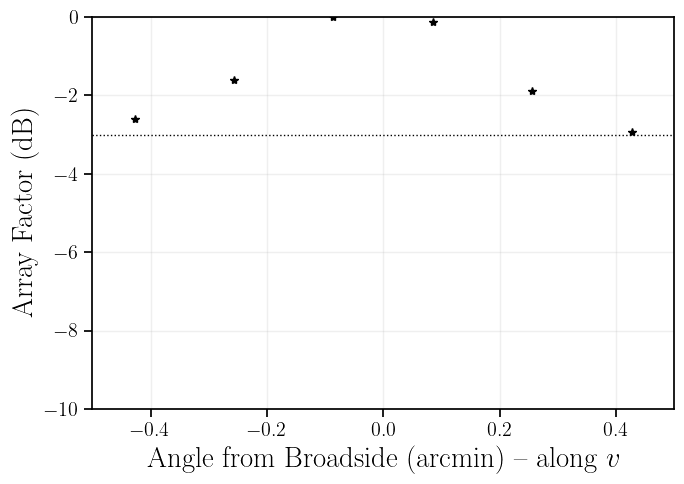

In [85]:
fig, frame = plt.subplots(figsize=(7, 5))

# frame.plot(ba_arcmin, decibel(af_v), lw=1, color='black')
frame.plot(ba_arcmin, decibel(af_v), marker='*', ls='', lw=1, color='black')
frame.axhline(y=-3, color='black', ls=':', lw=1)

frame.update(dict(
    xlabel=r'Angle from Broadside (arcmin) -- along $v$',
    ylabel=r'Array Factor (dB)',
    xlim=(-0.5, 0.5),
    # xlim=(ba_arcmin.min(), ba_arcmin.max()),
    # xticks=np.arange(-1, 1.5, 0.5),
    # ylim=(-40, 0)
    ylim=(-10, 0)
))

frame.grid(alpha=0.2)

fig.tight_layout()
plt.show()

In [88]:
idx_half = af_u.size // 2
idx_left = arg_closest(decibel(af_u[:idx_half]), -3)
idx_right = arg_closest(decibel(af_u[idx_half:]), -3) + idx_half

print(ba_arcmin[idx_left])
print(ba_arcmin[idx_right])

fwhm_u = np.abs(ba_arcmin[idx_left] - ba_arcmin[idx_right])

idx_left = arg_closest(decibel(af_v[:af_v.size // 2]), -3)
idx_right = arg_closest(decibel(af_v[af_v.size // 2:]), -3) + idx_half

print(ba_arcmin[idx_left])
print(ba_arcmin[idx_right])

fwhm_v = np.abs(ba_arcmin[idx_left] - ba_arcmin[idx_right])

print('FWHM = {:.2f} arcmin - along u'.format(fwhm_u))
print('FWHM = {:.2f} arcmin - along v'.format(fwhm_v))

-0.42758044523019867
0.42758044523019867
-0.5986126248034498
0.42758044523019867
FWHM = 0.86 arcmin - along u
FWHM = 1.03 arcmin - along v
